In [1]:
%%capture
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
from neuronunit.optimisation.optimization_management import test_all_objective_test
import numpy as np
from IPython.display import display, HTML
from neuronunit.plottools import plot_score_history1
from neuronunit.optimisation.optimization_management import check_binary_match
from neuronunit.optimisation.optimization_management import inject_and_plot_model, TSD
import pandas as pd

# Simulated Data 
and select model parameters that are free to vary


In [2]:
model_type="HH"
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
params = MODEL_PARAMS[model_type];
fps = params.keys()

In [3]:

sim_tests, OM, target = test_all_objective_test(fps,model_type=model_type)


Random simulated data tests made



# Meta Parameters

In [4]:
MU = 8
NGEN = 8
print(target.attrs)
hold_constant = {'E_L':target.attrs['E_L'],'E_K':target.attrs['E_K'],'E_Na':target.attrs['E_Na']}

{'g_K': 37.192778130794046, 'g_Na': 211.82447405145408, 'g_L': 0.10051253579556972, 'C_m': 0.9601364733465225, 'E_L': -66.59054796370198, 'E_K': -85.00608948829378, 'E_Na': 120.82641173459353, 'vr': -63.744540678034475, 'Vr': -72.12184267037705}


Lets look at a target models output data. We are searching for spike features that align with this waveform (and passive tests).

<Figure size 640x480 with 0 Axes>

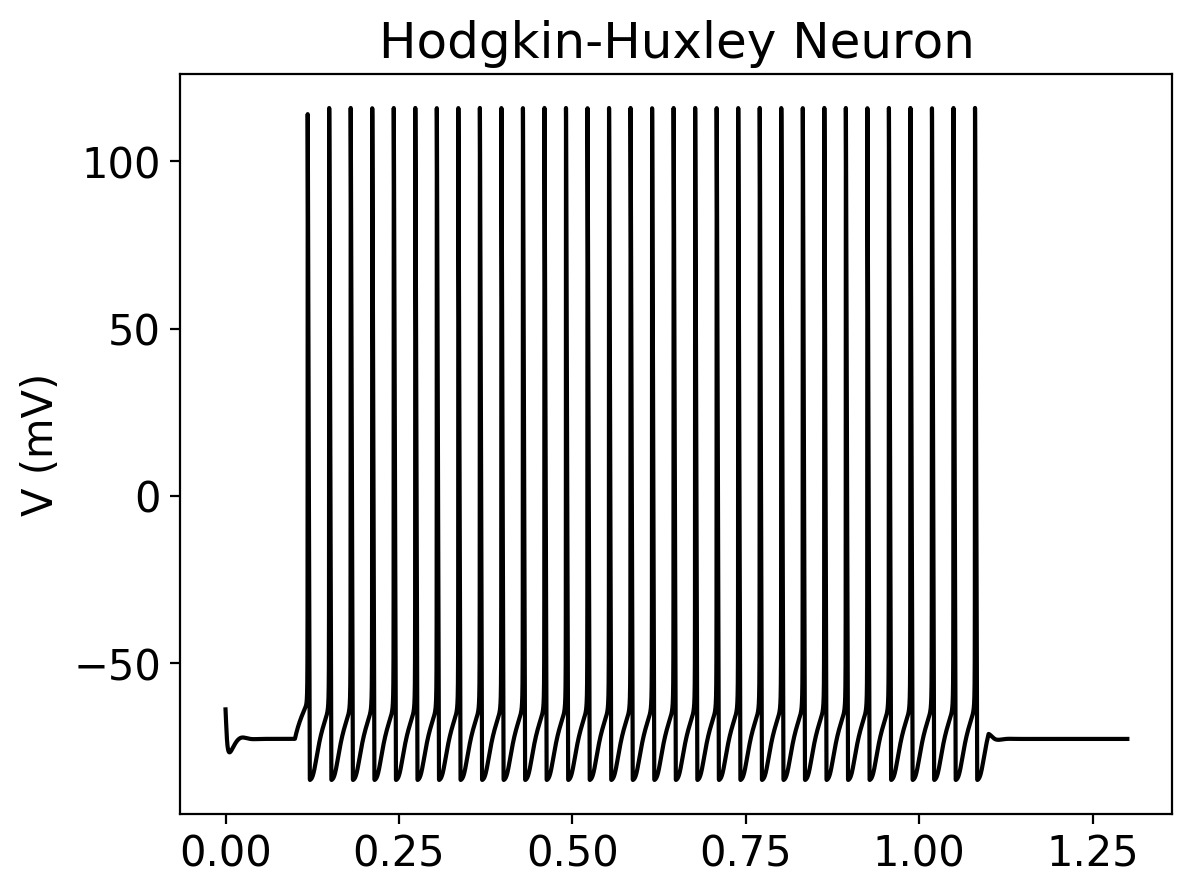

In [5]:

_,plt = inject_and_plot_model(target)
plt.show()

In [6]:


results = sim_tests.optimize(backend=model_type,\
        protocol={'allen': False, 'elephant': True},\
            MU=MU,NGEN=NGEN,plot=True,free_parameters=fps, \
                             hold_constant = hold_constant)


GA Generation Progress: 100%|██████████| 7/7 [1:25:30<00:00, 732.96s/it]


In [7]:
results['pf'][0].dtc.SA

RheobaseTest                       0.003255
TimeConstantTest                   0.001918
RestingPotentialTest               3.265747
InputResistanceTest               51.440000
CapacitanceTest                    0.125200
InjectedCurrentAPWidthTest         0.013308
InjectedCurrentAPAmplitudeTest     0.000569
InjectedCurrentAPThresholdTest     0.017844
dtype: float64

In [8]:
opt = results['pf'][0].dtc
OM.tests = opt.tests
opt = OM.format_test(opt)
opt.self_evaluate()
opt = OM.get_agreement(opt)
display(opt.agreement)
params = MODEL_PARAMS["HH"]
params

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,0.8987545967102051 pA,115.28120875596659 ms,-72.5668362091173 mV,9343816041.012701 kg*m**2/(s**3*A**2),1.2337701026000956e-11 s**4*A**2/(kg*m**2),0.002778750000000001 s,154.80933473942193 mV,-38.89672381938372 mV,NaN
predictions,1.593017578125 pA,115.83491870689534 ms,-86.10866506746952 mV,13337269029.445597 kg*m**2/(s**3*A**2),8.6850552726468e-12 s**4*A**2/(kg*m**2),0.0028708333333333337 s,154.5886555529912 mV,-37.172249536101944 mV,NaN
scores,0.00325511,0.00191801,3.26575,51.44,0.1252,0.0133079,0.00056885,0.0178438,277.393653


{'E_L': (-51.700950000000006, -86.16825),
 'E_K': (-67.5, -112.5),
 'E_Na': (90.0, 150.0),
 'g_L': (0.07500000000000001, 0.125),
 'g_K': (27.0, 45.0),
 'g_Na': (150.0, 250.0),
 'C_m': (0.75, 1.25),
 'vr': (-51.700950000000006, -86.16825),
 'Vr': (-51.700950000000006, -86.16825)}

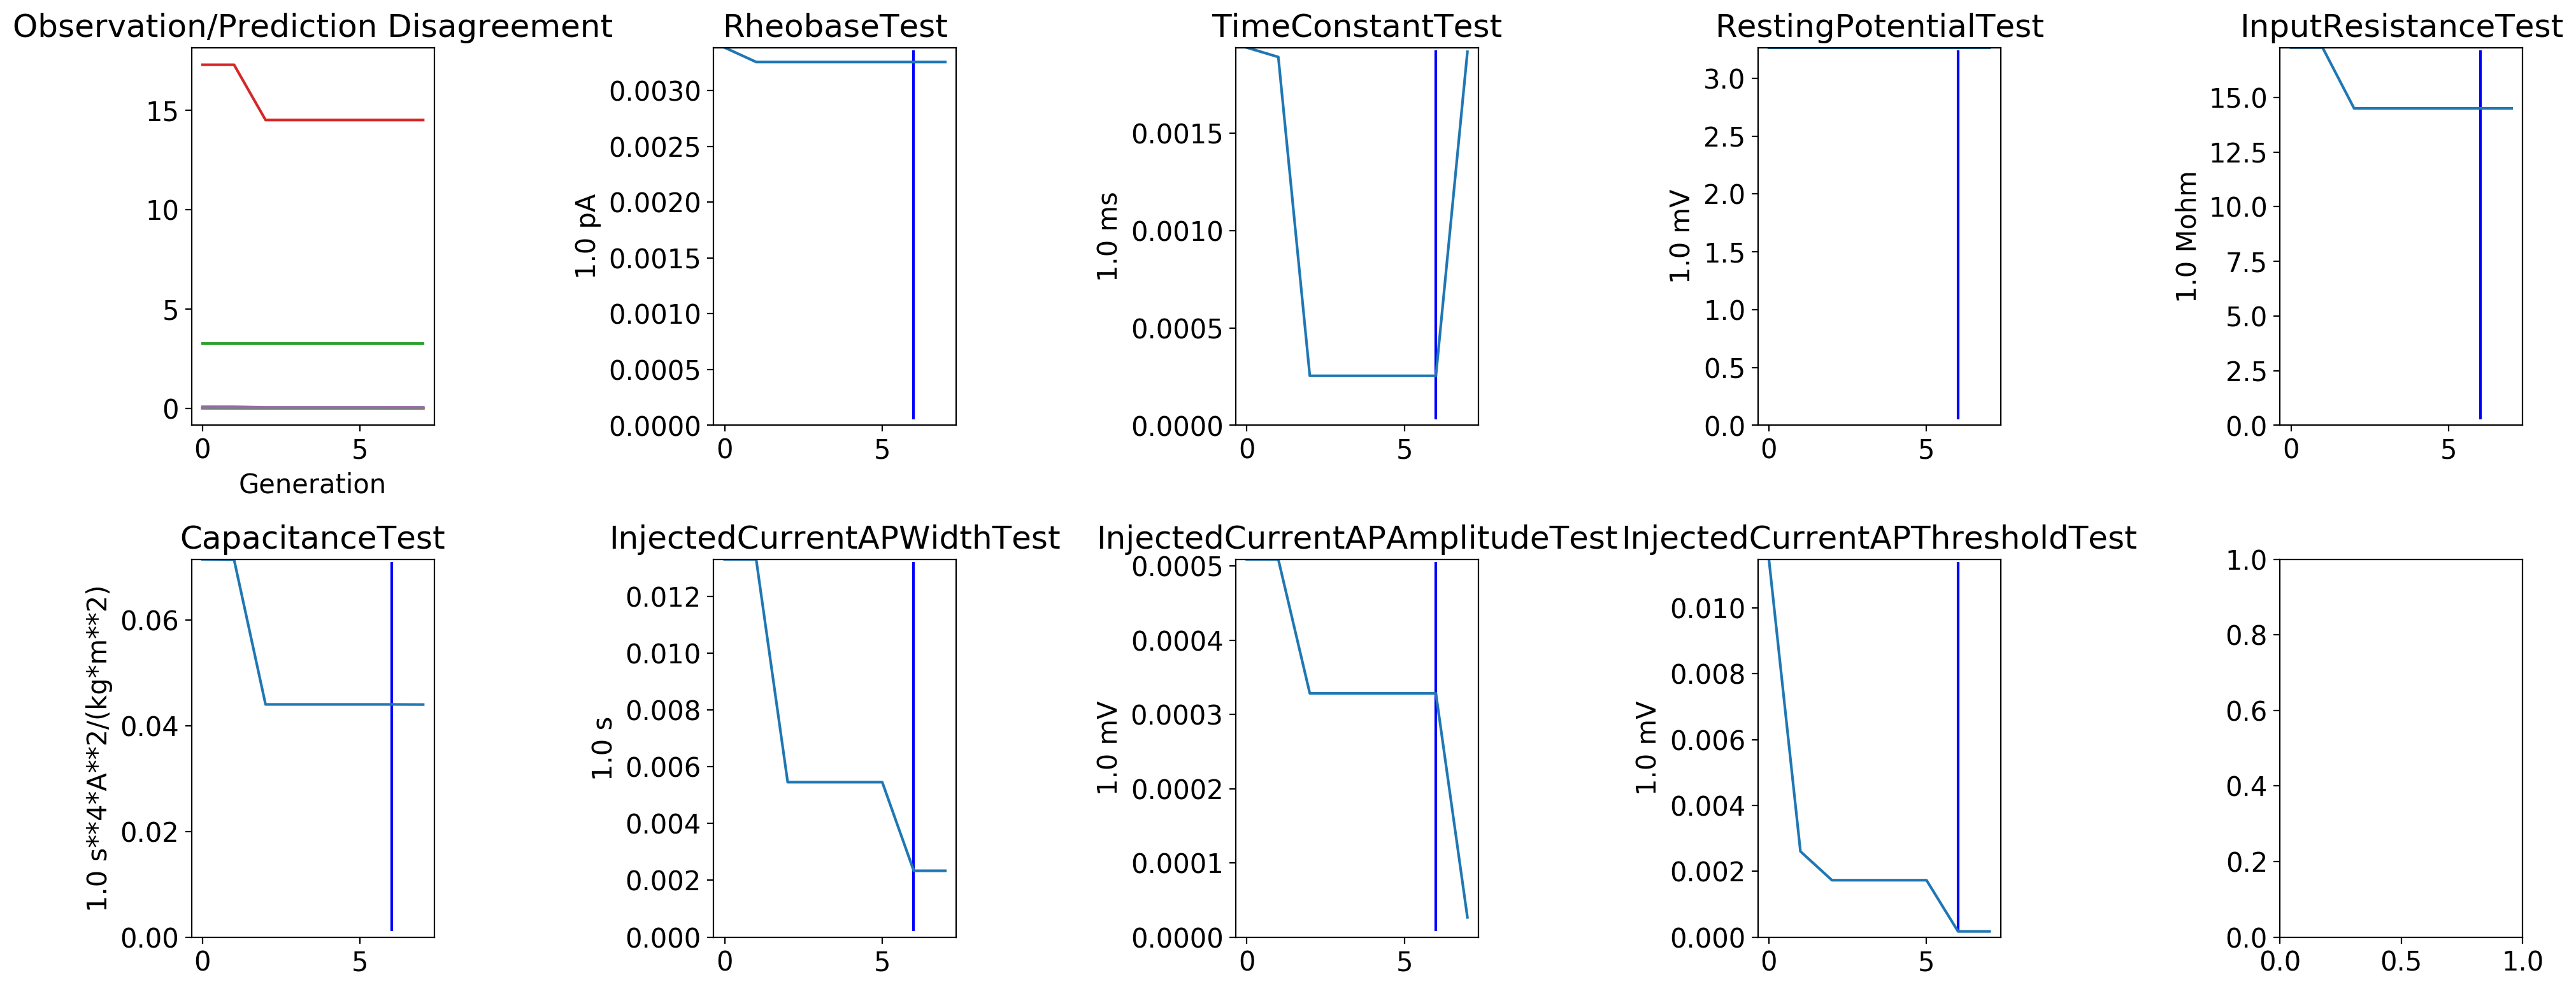

In [9]:

plt = plot_score_history1(results)
plt.show()


<Figure size 640x480 with 0 Axes>

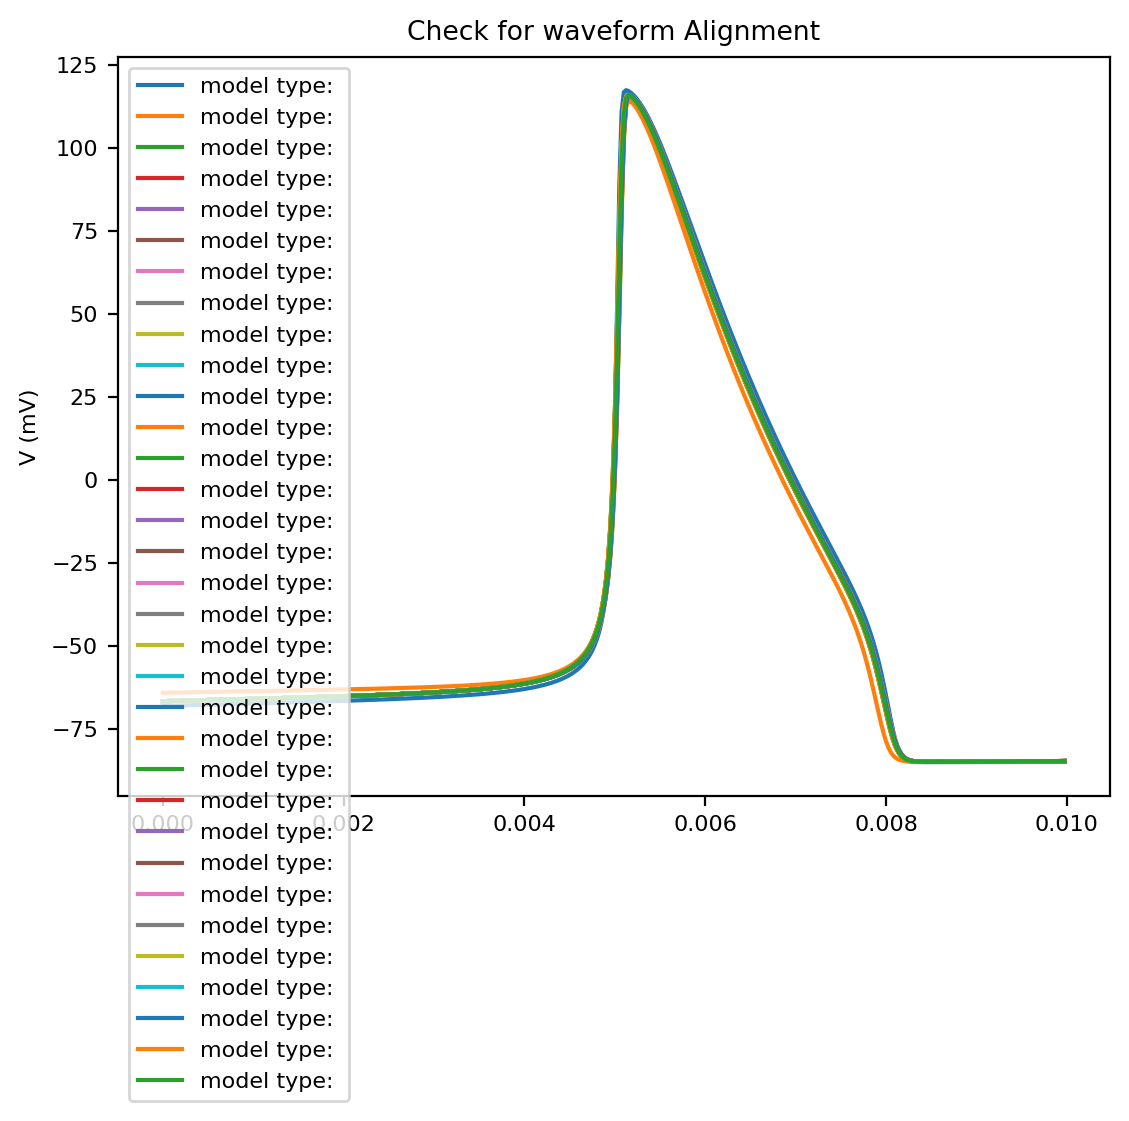

In [10]:
model = target.dtc_to_model()
check_binary_match(opt,target,snippets=True)
target = OM.format_test(target)
simulated_data_tests = target.tests
#


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

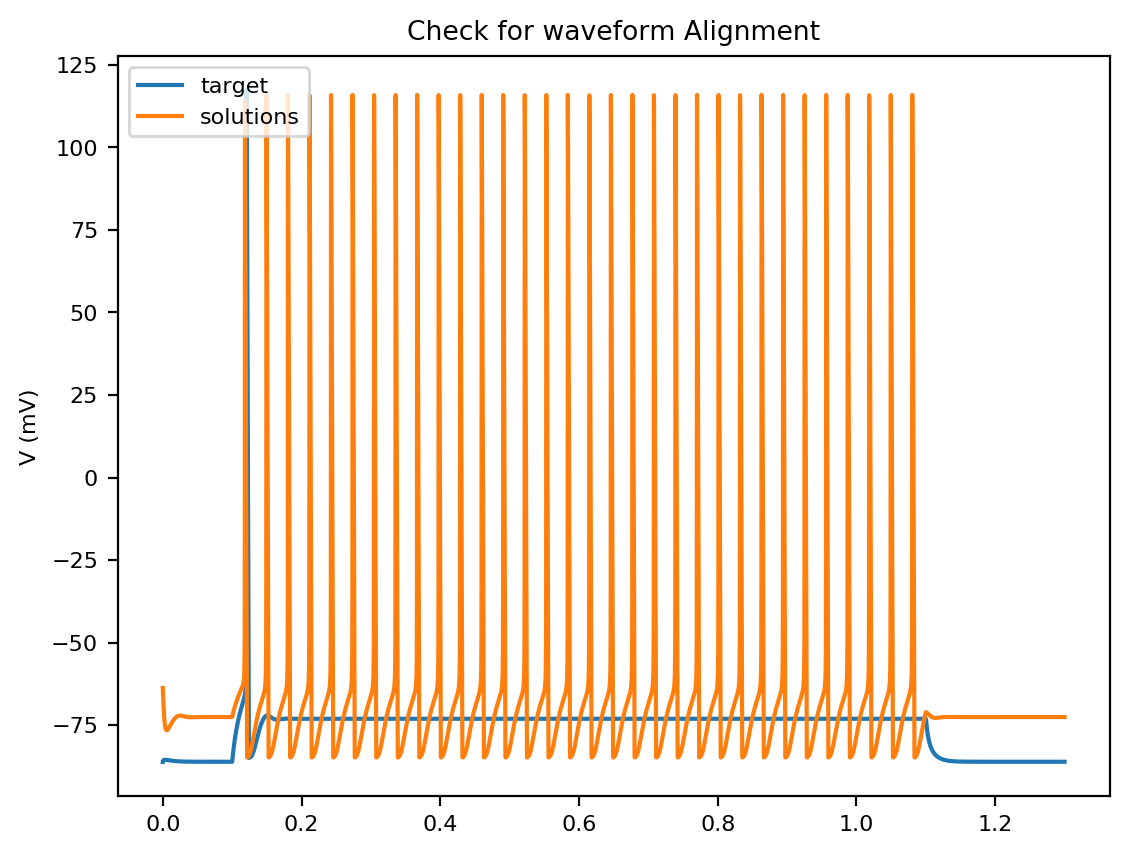

In [11]:
check_binary_match(opt,target,snippets=False)


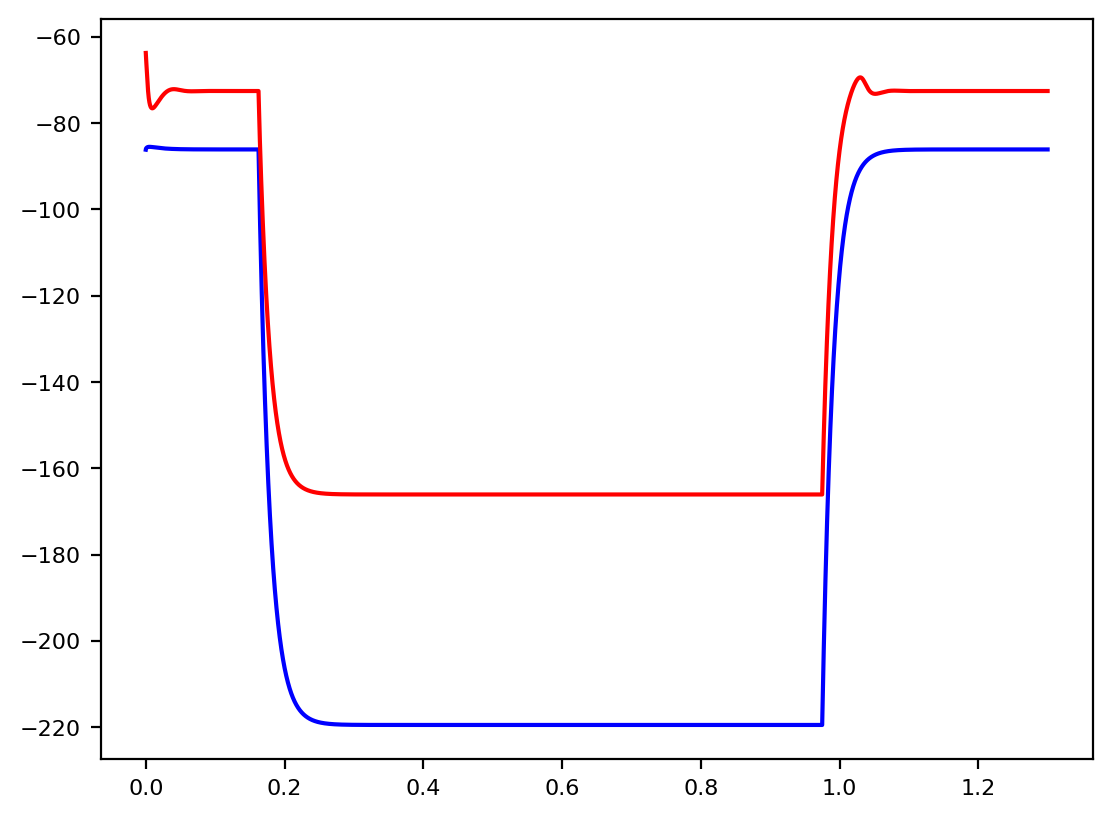

In [12]:

import quantities as pq
tm = target.dtc_to_model()

model = opt.dtc_to_model()
uc = {'amplitude':-10*pq.pA,'duration':500*pq.ms,'delay':100*pq.ms}
model.inject_square_current(uc)
vm1 = model.get_membrane_potential()
tm.inject_square_current(uc)
vm0 = tm.get_membrane_potential()
plt.plot(vm1.times, vm1.magnitude, c='b',label=str('opt ADEXP'))#+str(model.attrs['a']))
plt.plot(vm0.times, vm0.magnitude, c='r',label=str('target HH'))#+str(model.attrs['a']))

plt.show()


In [13]:
display(pd.DataFrame([opt.attrs]))
import copy
temp = {}
for k in opt.attrs.keys():
    temp[k] = target.attrs[k]
display(pd.DataFrame([temp]))

,C_m,E_K,E_L,E_Na,Vr,g_K,g_L,g_Na,vr
0,0.75,-85.006089,-86.16825,120.826412,-86.16825,44.312386,0.075,248.741223,-86.16825


,C_m,E_K,E_L,E_Na,Vr,g_K,g_L,g_Na,vr
0,0.960136,-85.006089,-66.590548,120.826412,-72.121843,37.192778,0.100513,211.824474,-63.744541


What where the values of model parameters that where held constant?

Nothing was held constant, and that is a bit why optimization parameters results where not perfect. 

The optimization problem was defined in an overly ambitious way.


In [14]:
df0 = opt.dtc_to_model().default_attrs
df1 = target.dtc_to_model().default_attrs
hc = {}
for k,v in df0.items():
    if k not in opt.attrs.keys():
        assert df0[k] == df1[k]
        hc[k] = v        
display(pd.DataFrame([hc]))     

""
0


In [15]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS

a_range = MODEL_PARAMS["HH"]['g_Na']
grid_a = np.linspace(a_range[0],a_range[1],10)
b_range = MODEL_PARAMS["HH"]['g_K']
grid_b = np.linspace(b_range[0],b_range[1],10);

100%|██████████| 10/10 [20:06<00:00, 120.62s/it]


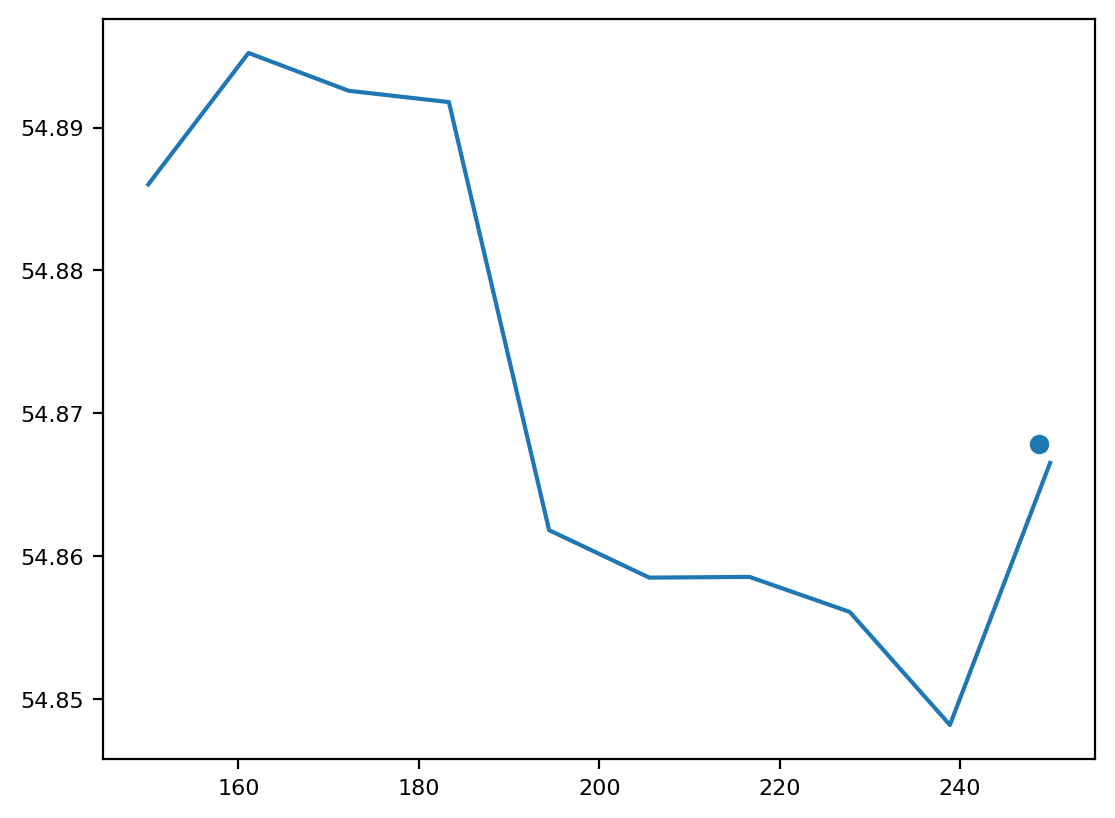

In [16]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['g_Na'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)
for a in tqdm(grid_a):
    # non random mutation
    mutant.attrs['g_Na'] = a
    # Evaluate NU test suite
    try:
        mutant.self_evaluate()
        fit = np.sum(mutant.SA.values)

    except:
        fit = 100
    # sum components (optional)
    collect.append(fit)
plt.plot(grid_a,collect)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')
    

In [17]:
%time
pred = opt.tests[0].generate_prediction(opt.dtc_to_model())
print(pred)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
{'value': array(1.59301758) * pA}


In [20]:
OM = target.dtc_to_opt_man()
out = OM.random_search(target,20)

warning please add whether or not model should be scored on rheobase to protocol


In [19]:
from neuronunit.tests.fi import RheobaseTestP, RheobaseTest
rtp = RheobaseTestP(opt.tests[0].observation)
rts = RheobaseTest(opt.tests[0].observation)
print(opt.tests[0])

RheobaseTest


In [ ]:
%%time
for p in results['pop'][0:9]:
    pred = rtp.generate_prediction(p.dtc.dtc_to_model())
    print(pred)

In [ ]:
%%time
for p in results['pop'][0:9]:
    pred = rts.generate_prediction(p.dtc.dtc_to_model())
    print(pred)